## 1. Install & Imports

In [0]:
# Install torch 0.4 
# google colab does not come with torch installed.

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# To install pillow 5.3.0,
#   first uninstall the older version

!pip uninstall -y Pillow
!pip install Pillow==5.3.0

import PIL
print('installed ', PIL.PILLOW_VERSION)

# this should print 5.3.0
# If it doesn't, then restart your runtime:
#   Menu > Runtime > Restart Runtime

Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
installed  5.3.0


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from collections import OrderedDict

import torch
import torchvision
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms

In [0]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## 2. Load, Prepare & Visualize Data

In [0]:
# download the flower dataset
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!rm -r flower_data || true
!unzip -qq flower_data.zip
!ls flower_data

train  valid


In [0]:
# map data with respective directories
train_dir = 'flower_data/train'
valid_dir = 'flower_data/valid'

dirs = {'train': train_dir, 
        'valid': valid_dir}

### Define *tranforms*, load *datasets* & then define *dataloaders*

In [0]:
# define batch size
batch_size = 32

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(dirs[x], transform=data_transforms[x])
    for x in ['train', 'valid']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'valid']
}

dataset_sizes = {
    x: len(image_datasets[x])
    for x in ['train', 'valid']
}

class_names = image_datasets['train'].classes

### Map flower names with catergorical numerals

In [0]:
with open('cat_to_name.json', 'r') as f:
    label_map = json.load(f)

### Visualize some images

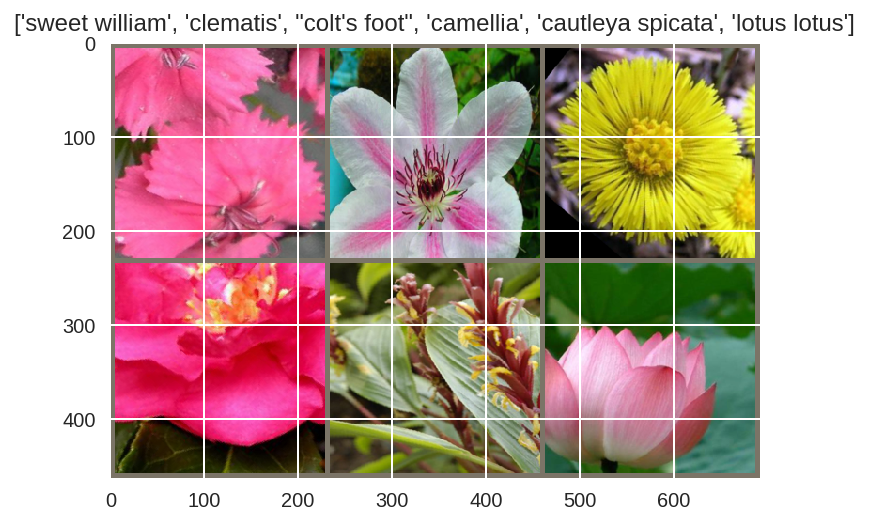

In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
print_n = 6
inputs, classes = next(iter(dataloaders['train']))
inputs, classes = inputs[:print_n], classes[:print_n]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow = 3, padding = 5)

imshow(out, title=[label_map[class_names[x]] for x in classes])

# 3. Define model

### Use pretrained model

In [0]:
model = models.vgg19(pretrained=True)
model.classifier

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 81530440.62it/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Create our classifier
`in_features` in first NN layer is 25088

`out_features` in last NN layer is 102

In [0]:
classifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(4096, 4096)),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p=0.5)),
        ('fc2', nn.Linear(4096, 102)),
        ('output', nn.LogSoftmax(dim=1))  
    ])
)

In [0]:
# Ensure that we don't update weights in pretrained model
for param in model.parameters():
    param.requires_grad = False

In [0]:
# Replace classifier of the pretrained model with our classifier
model.classifier = classifier

# 4. Train the model

In [0]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=15, device='cuda'):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# Number of epochs
eps=10

In [0]:
model_ft = train_model(model, criteria, optimizer, sched, eps, device)

Epoch 1/10
----------
train Loss: 3.2677 Acc: 0.3327
valid Loss: 1.1713 Acc: 0.6834

Epoch 2/10
----------
train Loss: 1.9767 Acc: 0.5075
valid Loss: 0.8127 Acc: 0.7800

Epoch 3/10
----------
train Loss: 1.7746 Acc: 0.5539
valid Loss: 0.7635 Acc: 0.7885

Epoch 4/10
----------
train Loss: 1.7152 Acc: 0.5681
valid Loss: 0.6415 Acc: 0.8178

Epoch 5/10
----------
train Loss: 1.3314 Acc: 0.6409
valid Loss: 0.5217 Acc: 0.8533

Epoch 6/10
----------
train Loss: 1.1929 Acc: 0.6819
valid Loss: 0.4837 Acc: 0.8643

Epoch 7/10
----------
train Loss: 1.1077 Acc: 0.7012
valid Loss: 0.4550 Acc: 0.8692

Epoch 8/10
----------
train Loss: 1.0589 Acc: 0.7157
valid Loss: 0.4338 Acc: 0.8802

Epoch 9/10
----------
train Loss: 1.0352 Acc: 0.7245
valid Loss: 0.4298 Acc: 0.8839

Epoch 10/10
----------
train Loss: 0.9914 Acc: 0.7314
valid Loss: 0.4291 Acc: 0.8814

Training complete in 45m 57s
Best val Acc: 0.883863


# 5. Saving the model

In [0]:
model.class_to_idx = image_datasets['train'].class_to_idx
model.cpu()
torch.save({'arch': 'vgg19_02',
            'state_dict': model.state_dict(), 
            'class_to_idx': model.class_to_idx}, 
            'vgg19_02.pth') 

### Save to Drive for future use

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls '/content/gdrive/My Drive/Deep Learning'

'#side project plan.gdoc'   vgg19_low_acc.pt


In [0]:
model_save_name = 'vgg19_02.pt'
path = F"/content/gdrive/My Drive/Deep Learning/{model_save_name}" 
torch.save(model.state_dict(), path)